## Corpus 전처리하기

In [1]:
text = "You say goodbye and I say hello."

In [2]:
text = text.lower().replace('.', ' .')

In [3]:
text

'you say goodbye and i say hello .'

In [4]:
words = text.split(' ')

In [5]:
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [6]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [7]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [8]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [9]:
word_to_id['hello']

5

In [10]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [11]:
def preprocess(text):
    text = text.lower().replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
            
    return co_matrix

In [13]:
def cos_similarity(x, y, eps=1e-8):
    nx = y / (np.sqrt(np.sum(x**2)) + eps)
    ny = x / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [14]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


## 유사 단어 랭킹 표시

In [15]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print(f"{query}를 찾을수 없습니다.")
        return
    
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f"{id_to_word[i]}: {similarity[i]}")
        
        count += 1
        if count >= top:
            return

In [16]:
most_similar('you', word_to_id, id_to_word, C, top=5)

goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


## PPMI 적용하기

In [17]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] + C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt & (total//100 + 1) == 0:
                    print(f"{100*cnt/total} 완료")
    return M

In [18]:
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('---------------')
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
---------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


## 차원 감소

In [19]:
import matplotlib.pyplot as plt

U, S, V = np.linalg.svd(W)

In [20]:
print(U[0])

[ 0.000e+00 -3.409e-01 -3.886e-16  1.205e-01  9.323e-01 -1.110e-16
  3.207e-16]


In [21]:
print(U[0, :2])

[ 0.    -0.341]


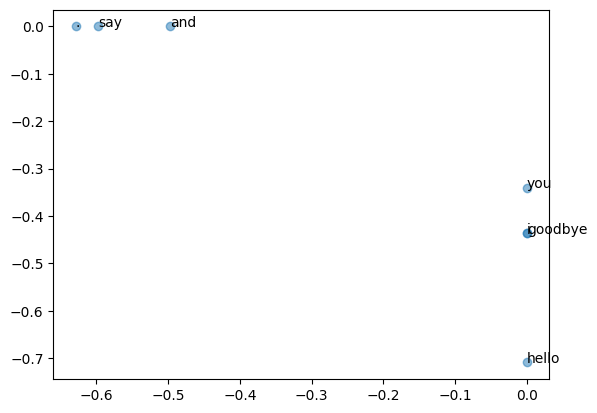

In [22]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

## PTB 데이터셋 활용하기

In [23]:
import sys
sys.path.append('.')
import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size', len(corpus))

corpus size 929589


In [24]:
from sklearn.utils.extmath import randomized_svd

window_size = 2
wordvec_size = 100

vocab_size = len(word_to_id)

C = create_co_matrix(corpus, vocab_size, window_size)

W = ppmi(C, verbose=False)

U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
    
word_ves = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_ves, top=5)
    

NameError: name 'word_vecs' is not defined

In [25]:
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_ves, top=5)

i: 0.7111190557479858
we: 0.596713125705719
do: 0.584316611289978
anybody: 0.559302568435669
'd: 0.4820948839187622
month: 0.6615439653396606
quarter: 0.6523621082305908
earlier: 0.6221667528152466
next: 0.6062678098678589
last: 0.582505464553833
auto: 0.6125226616859436
vehicle: 0.6022592782974243
luxury: 0.5814163088798523
cars: 0.5259524583816528
truck: 0.5142471790313721
motor: 0.7135969996452332
motors: 0.6655765175819397
mazda: 0.6247134804725647
nissan: 0.6135010123252869
lexus: 0.6070367097854614
